In [31]:
import random
import spacy
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from collections import Counter, defaultdict
from torchtext import data, datasets
from torchtext.vocab import GloVe
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.layers import Dropout, Dense, LSTM, Embedding, Bidirectional, GRU, TimeDistributed, Flatten
from keras.models import Sequential
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef, accuracy_score, classification_report, confusion_matrix
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
import warnings
import logging
logging.basicConfig(level=logging.INFO)

%matplotlib inline

In [5]:
np.random.seed(42)

# Data Exploration

In [2]:
# For tokenization
TEXT = data.Field(tokenize='spacy',
                  tokenizer_language='en_core_web_sm',
                  include_lengths=True)
# For multi-class classification labels
LABEL = data.LabelField()
# Load the TREC dataset
train_data, test_data = datasets.TREC.splits(TEXT, LABEL, fine_grained=False)

In [4]:
print("No. of training samples:",len(train_data.examples))
print("No. of testing samples:",len(test_data.examples))

No. of training samples: 5452
No. of testing samples: 500


In [4]:
for i in range(10):
    print(vars(train_data.examples[i]))

{'text': ['How', 'did', 'serfdom', 'develop', 'in', 'and', 'then', 'leave', 'Russia', '?'], 'label': 'DESC'}
{'text': ['What', 'films', 'featured', 'the', 'character', 'Popeye', 'Doyle', '?'], 'label': 'ENTY'}
{'text': ['How', 'can', 'I', 'find', 'a', 'list', 'of', 'celebrities', "'", 'real', 'names', '?'], 'label': 'DESC'}
{'text': ['What', 'fowl', 'grabs', 'the', 'spotlight', 'after', 'the', 'Chinese', 'Year', 'of', 'the', 'Monkey', '?'], 'label': 'ENTY'}
{'text': ['What', 'is', 'the', 'full', 'form', 'of', '.com', '?'], 'label': 'ABBR'}
{'text': ['What', 'contemptible', 'scoundrel', 'stole', 'the', 'cork', 'from', 'my', 'lunch', '?'], 'label': 'HUM'}
{'text': ['What', 'team', 'did', 'baseball', "'s", 'St.', 'Louis', 'Browns', 'become', '?'], 'label': 'HUM'}
{'text': ['What', 'is', 'the', 'oldest', 'profession', '?'], 'label': 'HUM'}
{'text': ['What', 'are', 'liver', 'enzymes', '?'], 'label': 'DESC'}
{'text': ['Name', 'the', 'scar', '-', 'faced', 'bounty', 'hunter', 'of', 'The', 'Old

In [4]:
for i in range(10):
    print(vars(test_data.examples[i]))

{'text': ['How', 'far', 'is', 'it', 'from', 'Denver', 'to', 'Aspen', '?'], 'label': 'NUM'}
{'text': ['What', 'county', 'is', 'Modesto', ',', 'California', 'in', '?'], 'label': 'LOC'}
{'text': ['Who', 'was', 'Galileo', '?'], 'label': 'HUM'}
{'text': ['What', 'is', 'an', 'atom', '?'], 'label': 'DESC'}
{'text': ['When', 'did', 'Hawaii', 'become', 'a', 'state', '?'], 'label': 'NUM'}
{'text': ['How', 'tall', 'is', 'the', 'Sears', 'Building', '?'], 'label': 'NUM'}
{'text': ['George', 'Bush', 'purchased', 'a', 'small', 'interest', 'in', 'which', 'baseball', 'team', '?'], 'label': 'HUM'}
{'text': ['What', 'is', 'Australia', "'s", 'national', 'flower', '?'], 'label': 'ENTY'}
{'text': ['Why', 'does', 'the', 'moon', 'turn', 'orange', '?'], 'label': 'DESC'}
{'text': ['What', 'is', 'autism', '?'], 'label': 'DESC'}


Unique labels in training data: ['ABBR', 'DESC', 'ENTY', 'HUM', 'LOC', 'NUM']
Counts: {'DESC': 1162, 'ENTY': 1250, 'ABBR': 86, 'HUM': 1223, 'NUM': 896, 'LOC': 835}
Num unique: 6


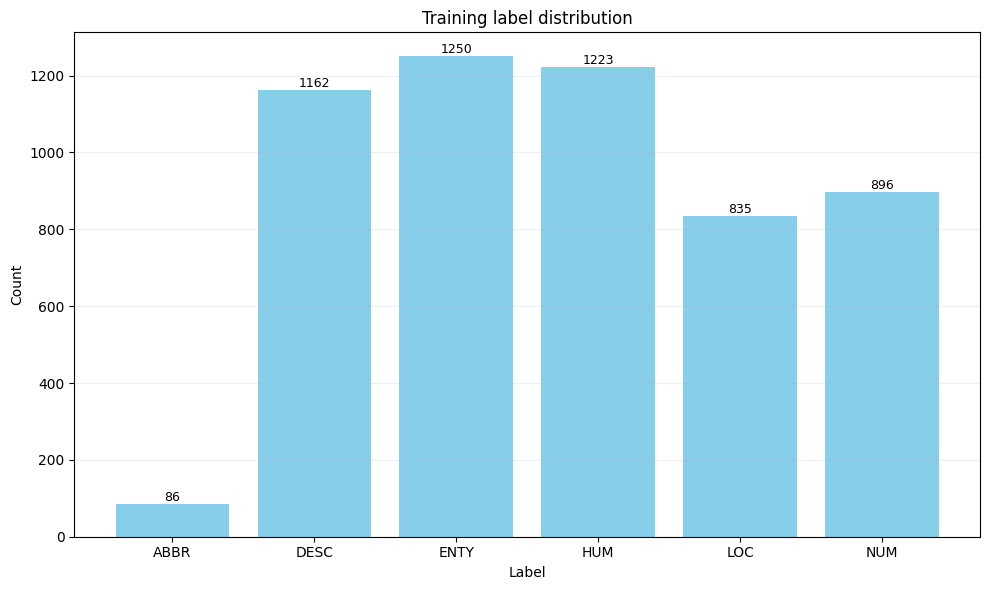

In [7]:
labels = [ex.label for ex in train_data.examples]
unique_labels = sorted(set(labels))
counts = Counter(labels)
bars = [counts[label] for label in unique_labels]

print("Unique labels in training data:", unique_labels)
print("Counts:", dict(counts))
print("Num unique:", len(unique_labels))

# Plotting the label distribution
plt.figure(figsize=(10,6))
bar_plots = plt.bar(unique_labels, bars, color='skyblue')
plt.title("Training label distribution")
plt.xlabel("Label")
plt.ylabel("Count")
# plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.2)

# Add counts on top of bars
for rect, cnt in zip(bar_plots, bars):
    y = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2, y, str(cnt),
             ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

Unique labels in test data: ['ABBR', 'DESC', 'ENTY', 'HUM', 'LOC', 'NUM']
Counts: {'NUM': 113, 'LOC': 81, 'HUM': 65, 'DESC': 138, 'ENTY': 94, 'ABBR': 9}
Num unique: 6


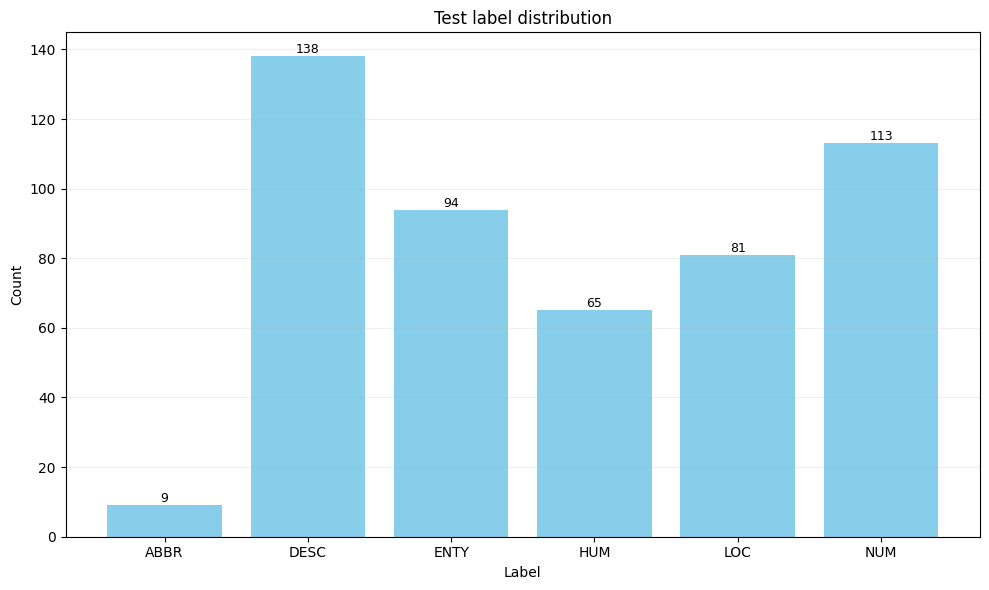

In [9]:
labels = [ex.label for ex in test_data.examples]
unique_labels = sorted(set(labels))
counts = Counter(labels)
bars = [counts[label] for label in unique_labels]

print("Unique labels in test data:", unique_labels)
print("Counts:", dict(counts))
print("Num unique:", len(unique_labels))

# Plotting the label distribution
plt.figure(figsize=(10,6))
bar_plots = plt.bar(unique_labels, bars, color='skyblue')
plt.title("Test label distribution")
plt.xlabel("Label")
plt.ylabel("Count")
# plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.2)

# Add counts on top of bars
for rect, cnt in zip(bar_plots, bars):
    y = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2, y, str(cnt),
             ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

# Data Preprocessing

In [ ]:
# Split training data into train and validation sets
all_examples = train_data.examples
all_labels = [ex.label for ex in all_examples]

train_examples, valid_examples = train_test_split(
    all_examples,
    test_size=0.2,
    random_state=42,
    stratify=all_labels,  # Ensures class proportions in both splits
)

# Rebuild torchtext Datasets using the same Fields (vocab stays the same)
train_data = data.Dataset(train_examples, fields=train_data.fields)
valid_data = data.Dataset(valid_examples, fields=train_data.fields)

# Verify each split contains all 6 categories
print("Train label counts:", Counter([ex.label for ex in train_data.examples]))
print("Valid label counts:", Counter([ex.label for ex in valid_data.examples]))

Train label counts: Counter({'HUM': 800, 'ENTY': 787, 'DESC': 725, 'NUM': 591, 'LOC': 533, 'ABBR': 53})
Valid label counts: Counter({'HUM': 200, 'ENTY': 197, 'DESC': 181, 'NUM': 148, 'LOC': 134, 'ABBR': 13})


In [ ]:
# 1) Extract raw texts and labels from torchtext Datasets
def to_texts_labels(ds):
    texts, labels = [], []
    for ex in ds.examples:
        t = ex.text
        if isinstance(t, list):
            t = " ".join(t) # Normalize tokens back to text
        texts.append(t)
        labels.append(ex.label)
    return texts, labels

train_texts, train_labels = to_texts_labels(train_data)
valid_texts, valid_labels = to_texts_labels(valid_data)
test_texts,  test_labels  = to_texts_labels(test_data)

In [15]:
# 2) Encode labels
le = LabelEncoder()
y_train = to_categorical(le.fit_transform(train_labels))
y_valid = to_categorical(le.transform(valid_labels))
y_test  = to_categorical(le.transform(test_labels))
nclasses = y_train.shape[1]

In [ ]:
# 3) Tokenize with Keras and pad
MAX_VOCAB = 20000
MAX_LEN = 50
tok = Tokenizer(num_words=MAX_VOCAB, oov_token="<unk>")
tok.fit_on_texts(train_texts)
# Pad sequences to ensure fixed length inputs for batching
X_train = pad_sequences(tok.texts_to_sequences(train_texts), maxlen=MAX_LEN, 
                        padding="post", truncating="post")
X_valid = pad_sequences(tok.texts_to_sequences(valid_texts), maxlen=MAX_LEN, 
                        padding="post", truncating="post")
X_test  = pad_sequences(tok.texts_to_sequences(test_texts),  maxlen=MAX_LEN, 
                        padding="post", truncating="post")

In [ ]:
# 4) Build embedding matrix from GloVe (100D)
# Ensures indices align with Keras word_index
EMB_DIM = 100
glove = GloVe(name="6B", dim=100)

word_index = tok.word_index # Word to index mapping from Keras Tokenizer
vocab_size = min(MAX_VOCAB, len(word_index) + 1)
emb_matrix = np.zeros((vocab_size, EMB_DIM), dtype="float32")

for w, i in word_index.items():
    if i >= vocab_size: 
        continue
    j = glove.stoi.get(w)
    if j is not None:
        emb_matrix[i] = glove.vectors[j].numpy()

# OOV handling: Give the OOV token a non-zero embedding
oov_idx = tok.word_index.get(tok.oov_token)
if oov_idx is not None and oov_idx < vocab_size:
    known = emb_matrix[emb_matrix.any(axis=1)]
    if known.size:
        emb_matrix[oov_idx] = known.mean(axis=0) # Mean of known vectors

INFO:torchtext.vocab:Loading vectors from .vector_cache\glove.6B.100d.txt.pt


In [32]:
# OOV Analysis
# a) Sets for fast membership checks
num_words = tok.num_words if tok.num_words is not None else (len(tok.word_index) + 1)
tokenizer_iv = {w for w, i in tok.word_index.items() if i < num_words}  # in-vocab for Tokenizer
glove_iv = set(glove.stoi.keys())                                        # in-vocab for GloVe

# b) Keras-consistent tokenization (same filters/lower/split as Tokenizer)
def keras_tokens(s: str):
    return text_to_word_sequence(s, filters=tok.filters, lower=tok.lower, split=tok.split)

# c) OOV detection on a single text
def oov_info_for_text(text: str):
    toks = keras_tokens(text)
    oov_tok = [w for w in toks if (w not in tok.word_index) or (tok.word_index[w] >= num_words)]
    oov_emb = [w for w in toks if w not in glove_iv]
    return {
        "tokenizer_oov_tokens": oov_tok,                 # occurrences (can repeat)
        "tokenizer_oov_unique": sorted(set(oov_tok)),    # types
        "embedding_oov_tokens": oov_emb,
        "embedding_oov_unique": sorted(set(oov_emb)),
    }

# Example on one sample
# print(oov_info_for_text(test_texts[0]))

# d) Aggregate by label/category
def oov_by_label(texts, labels):
    by_label = defaultdict(lambda: {
        "tok_oov_count": 0, "tok_total_tokens": 0, "tok_oov_types": set(),
        "emb_oov_count": 0, "emb_total_tokens": 0, "emb_oov_types": set(),
    })
    for text, lab in zip(texts, labels):
        toks = keras_tokens(text)
        tok_oov = [w for w in toks if (w not in tok.word_index) or (tok.word_index[w] >= num_words)]
        emb_oov = [w for w in toks if w not in glove_iv]

        agg = by_label[lab]
        agg["tok_oov_count"] += len(tok_oov)
        agg["tok_total_tokens"] += len(toks)
        agg["tok_oov_types"].update(tok_oov)

        agg["emb_oov_count"] += len(emb_oov)
        agg["emb_total_tokens"] += len(toks)
        agg["emb_oov_types"].update(emb_oov)

    # Format results: counts and rates per label
    summary = {}
    for lab, a in by_label.items():
        summary[lab] = {
            "tokenizer_oov_tokens": a["tok_oov_count"],
            "tokenizer_total_tokens": a["tok_total_tokens"],
            "tokenizer_oov_rate": a["tok_oov_count"] / max(1, a["tok_total_tokens"]),
            "tokenizer_oov_unique": len(a["tok_oov_types"]),
            "embedding_oov_tokens": a["emb_oov_count"],
            "embedding_total_tokens": a["emb_total_tokens"],
            "embedding_oov_rate": a["emb_oov_count"] / max(1, a["emb_total_tokens"]),
            "embedding_oov_unique": len(a["emb_oov_types"]),
        }
    return summary

# Run per split (choose train/valid/test as you need)
train_oov = oov_by_label(train_texts, train_labels)
valid_oov = oov_by_label(valid_texts, valid_labels)
test_oov  = oov_by_label(test_texts,  test_labels)

print("Per-label OOV on test:")
for lab, stats in test_oov.items():
    print(lab, stats)

# e) Global lists of OOV types (useful for inspection)
# Tokenizer OOV relative to top-K vocab (over test set)
test_tok_oov_types = sorted({
    w for txt in test_texts
    for w in keras_tokens(txt)
    if (w not in tok.word_index) or (tok.word_index[w] >= num_words)
})
# Embedding OOV types relative to GloVe
test_emb_oov_types = sorted({
    w for txt in test_texts
    for w in keras_tokens(txt)
    if w not in glove_iv
})

print("Tokenizer OOV unique (test):", len(test_tok_oov_types))
print("Embedding OOV unique (test):", len(test_emb_oov_types))

Per-label OOV on test:
NUM {'tokenizer_oov_tokens': 68, 'tokenizer_total_tokens': 836, 'tokenizer_oov_rate': 0.08133971291866028, 'tokenizer_oov_unique': 63, 'embedding_oov_tokens': 0, 'embedding_total_tokens': 836, 'embedding_oov_rate': 0.0, 'embedding_oov_unique': 0}
LOC {'tokenizer_oov_tokens': 62, 'tokenizer_total_tokens': 591, 'tokenizer_oov_rate': 0.10490693739424704, 'tokenizer_oov_unique': 62, 'embedding_oov_tokens': 2, 'embedding_total_tokens': 591, 'embedding_oov_rate': 0.00338409475465313, 'embedding_oov_unique': 2}
HUM {'tokenizer_oov_tokens': 32, 'tokenizer_total_tokens': 502, 'tokenizer_oov_rate': 0.06374501992031872, 'tokenizer_oov_unique': 32, 'embedding_oov_tokens': 0, 'embedding_total_tokens': 502, 'embedding_oov_rate': 0.0, 'embedding_oov_unique': 0}
DESC {'tokenizer_oov_tokens': 136, 'tokenizer_total_tokens': 542, 'tokenizer_oov_rate': 0.25092250922509224, 'tokenizer_oov_unique': 135, 'embedding_oov_tokens': 1, 'embedding_total_tokens': 542, 'embedding_oov_rate': 0.

# Model Training

In [33]:
# 5) Define and compile BiLSTM model (make sure EMBEDDING_DIM matches 100)
def build_bilstm(nclasses, vocab_size, emb_dim, max_len, emb_weights):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=emb_dim,
                        input_length=max_len,
                        weights=[emb_weights],
                        trainable=True)) # Load embedding matrix as weights
    model.add(Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=0.2)))
    # model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=0.2)))
    # model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64, recurrent_dropout=0.2)))
    # model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(nclasses, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_bilstm(nclasses, vocab_size, EMB_DIM, MAX_LEN, emb_matrix)

c:\Users\ASUS\anaconda3\envs\nlp-4\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [34]:
# 6) Train the model with early stopping
es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
start_time = time.time()

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=20, batch_size=64, callbacks=[es], verbose=1
)

end_time = time.time()
print("Training time:", end_time - start_time)

Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 40s 426ms/step - accuracy: 0.4480 - loss: 1.3581 - val_accuracy: 0.6827 - val_loss: 0.8959
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 382ms/step - accuracy: 0.7263 - loss: 0.7473 - val_accuracy: 0.7560 - val_loss: 0.7245
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 379ms/step - accuracy: 0.8040 - loss: 0.5427 - val_accuracy: 0.8053 - val_loss: 0.5737
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 384ms/step - accuracy: 0.8567 - loss: 0.3940 - val_accuracy: 0.8190 - val_loss: 0.4992
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 21s 382ms/step - accuracy: 0.9051 - loss: 0.2897 - val_accuracy: 0.8282 - val_loss: 0.5114
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 22s 392ms/step - accuracy: 0.9349 - loss: 0.2069 - val_accuracy: 0.8373 - val_loss: 0.5640
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 22s 397ms/step - accuracy: 0.9398 - loss: 0.1780 - val_accuracy: 0.8511 - val_loss: 0.5314
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 22s 393ms/step - accuracy: 0.9636 - loss: 0.1149 - val_accu

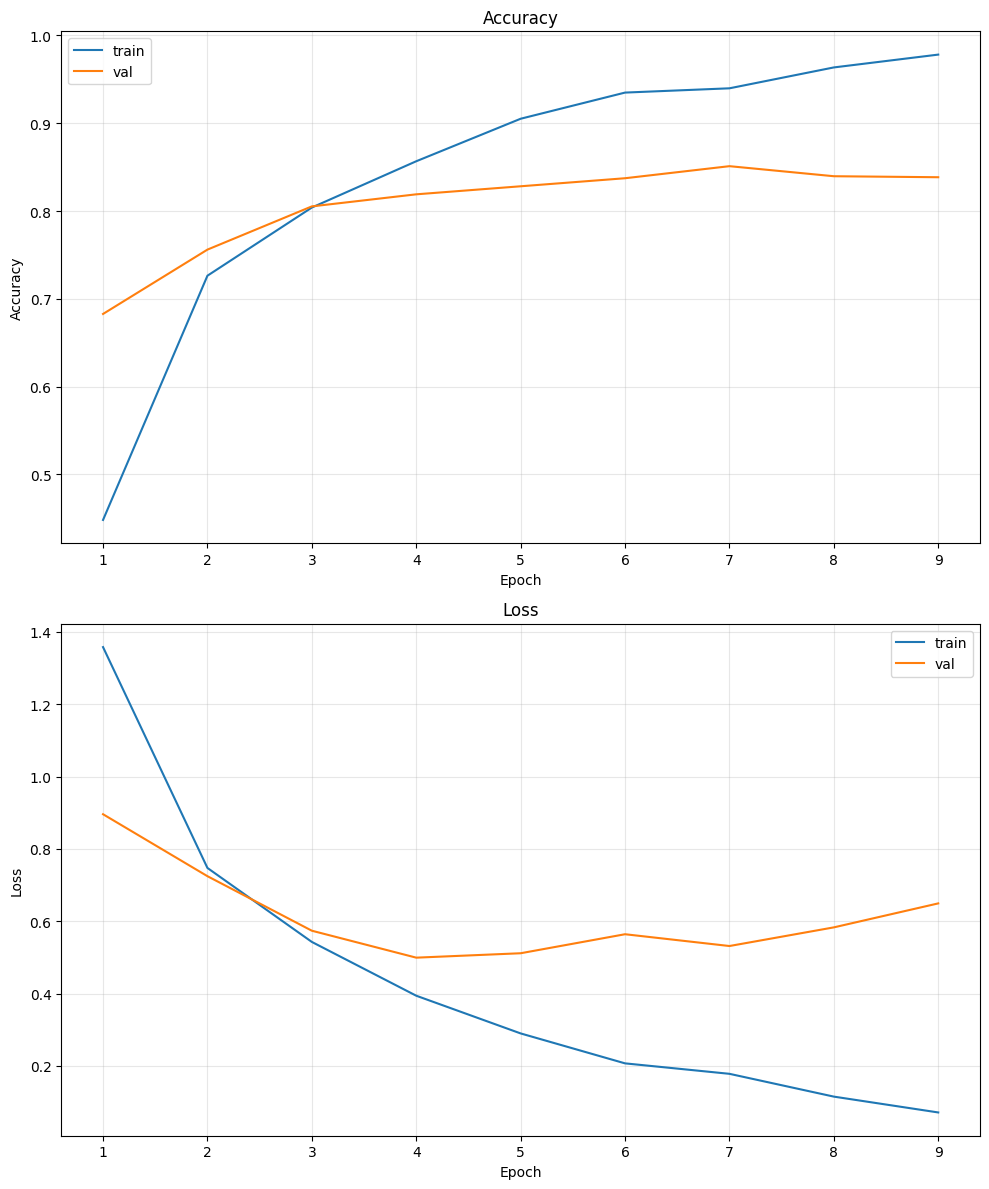

In [35]:
# 7) Plot accuracy and loss curves
def plot_history(history):
    h = history.history
    epochs = range(1, len(h["loss"]) + 1)

    # Handle possible key names
    acc = h.get("accuracy", h.get("acc"))
    val_acc = h.get("val_accuracy", h.get("val_acc"))
    loss = h.get("loss")
    val_loss = h.get("val_loss")

    plt.figure(figsize=(10, 12))

    # Accuracy
    plt.subplot(2, 1, 1)
    if acc is not None:
        plt.plot(epochs, acc, label="train")
    if val_acc is not None:
        plt.plot(epochs, val_acc, label="val")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(alpha=0.3)

    # Loss
    plt.subplot(2, 1, 2)
    if loss is not None:
        plt.plot(epochs, loss, label="train")
    if val_loss is not None:
        plt.plot(epochs, val_loss, label="val")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_history(history)

In [36]:
# 8) Evaluate on test set
y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

print("Test accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=le.classes_))

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step
Test accuracy: 0.854
              precision    recall  f1-score   support

        ABBR       1.00      0.11      0.20         9
        DESC       0.81      0.96      0.88       138
        ENTY       0.86      0.63      0.72        94
         HUM       0.88      0.89      0.89        65
         LOC       0.79      0.89      0.84        81
         NUM       0.96      0.92      0.94       113

    accuracy                           0.85       500
   macro avg       0.88      0.73      0.74       500
weighted avg       0.86      0.85      0.85       500



In [ ]:
# Topic-wise accuracy (fraction of each true class predicted correctly)
cm = confusion_matrix(y_true, y_pred, labels=range(len(le.classes_)))
per_class_acc = cm.diagonal() / cm.sum(axis=1).clip(min=1)

for i, cls in enumerate(le.classes_):
    print(f"{cls}: {per_class_acc[i]:.4f} (n={cm.sum(axis=1)[i]})")

# Optional dict if you need it programmatically
topic_acc = {cls: float(per_class_acc[i]) for i, cls in enumerate(le.classes_)}

In [37]:
# 9) Define and compile BiGRU model (make sure EMBEDDING_DIM matches 100)
def build_bigru(nclasses, vocab_size, emb_dim, max_len, emb_weights):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=emb_dim,
                        input_length=max_len,
                        weights=[emb_weights],
                        trainable=True)) # Load embedding matrix as weights
    model.add(Bidirectional(GRU(64, return_sequences=True, recurrent_dropout=0.2)))
    # model.add(Dropout(0.2))
    model.add(Bidirectional(GRU(64, return_sequences=True, recurrent_dropout=0.2)))
    # model.add(Dropout(0.2))
    model.add(Bidirectional(GRU(64, recurrent_dropout=0.2)))
    # model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(nclasses, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_bigru(nclasses, vocab_size, EMB_DIM, MAX_LEN, emb_matrix)

c:\Users\ASUS\anaconda3\envs\nlp-4\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [38]:
# 10) Train the model with early stopping
es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
start_time = time.time()

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=20, batch_size=64, callbacks=[es], verbose=1
)

end_time = time.time()
print("Training time:", end_time - start_time)

Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 39s 401ms/step - accuracy: 0.5426 - loss: 1.1808 - val_accuracy: 0.7171 - val_loss: 0.7994
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 206ms/step - accuracy: 0.7819 - loss: 0.6131 - val_accuracy: 0.7938 - val_loss: 0.5818
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 203ms/step - accuracy: 0.8492 - loss: 0.4249 - val_accuracy: 0.8328 - val_loss: 0.4780
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 12s 209ms/step - accuracy: 0.8980 - loss: 0.3111 - val_accuracy: 0.8431 - val_loss: 0.4528
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 198ms/step - accuracy: 0.9318 - loss: 0.2127 - val_accuracy: 0.8396 - val_loss: 0.4814
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 199ms/step - accuracy: 0.9550 - loss: 0.1386 - val_accuracy: 0.8431 - val_loss: 0.4847
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 198ms/step - accuracy: 0.9765 - loss: 0.0822 - val_accuracy: 0.8465 - val_loss: 0.5795
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 201ms/step - accuracy: 0.9831 - loss: 0.0527 - val_accu

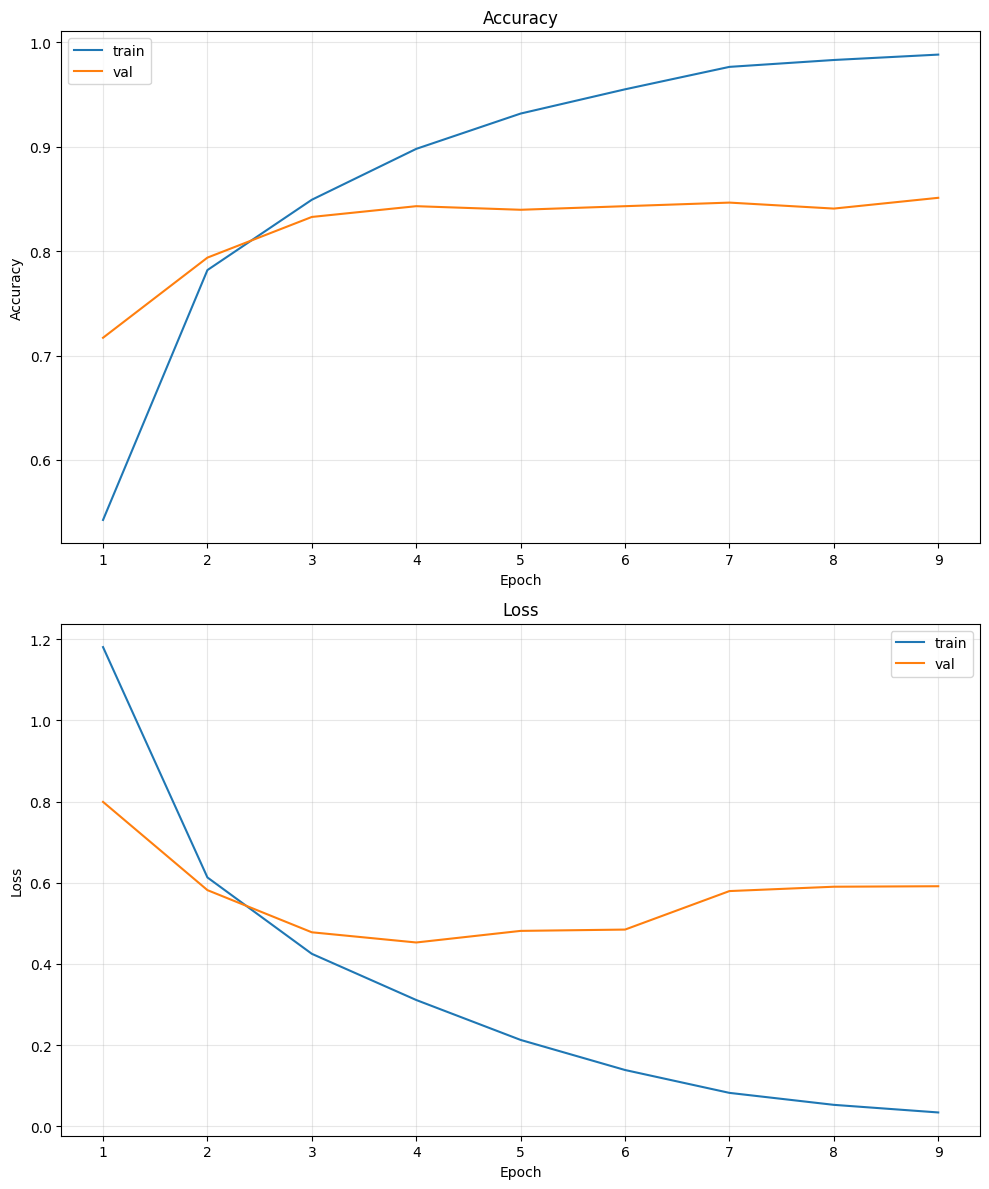

In [ ]:
# 11) Plot accuracy and loss curves
plot_history(history)

In [40]:
# 12) Evaluate on test set
y_pred = model.predict(X_test).argmax(axis=1)
y_true = y_test.argmax(axis=1)

print("Test accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=le.classes_))

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step
Test accuracy: 0.832
              precision    recall  f1-score   support

        ABBR       1.00      0.56      0.71         9
        DESC       0.73      0.98      0.84       138
        ENTY       0.88      0.60      0.71        94
         HUM       0.89      0.88      0.88        65
         LOC       0.79      0.95      0.87        81
         NUM       1.00      0.76      0.86       113

    accuracy                           0.83       500
   macro avg       0.88      0.79      0.81       500
weighted avg       0.86      0.83      0.83       500



In [ ]:
# Topic-wise accuracy (fraction of each true class predicted correctly)
cm = confusion_matrix(y_true, y_pred, labels=range(len(le.classes_)))
per_class_acc = cm.diagonal() / cm.sum(axis=1).clip(min=1)

for i, cls in enumerate(le.classes_):
    print(f"{cls}: {per_class_acc[i]:.4f} (n={cm.sum(axis=1)[i]})")

# Optional dict if you need it programmatically
topic_acc = {cls: float(per_class_acc[i]) for i, cls in enumerate(le.classes_)}

# Draft (from Data Preprocessing)

In [24]:
# Build vocabulary using training data
TEXT.build_vocab(train_data, vectors='glove.6B.100d', min_freq=1)
LABEL.build_vocab(train_data)

# Print vocabulary information
print(f'Vocabulary size: {len(TEXT.vocab)}')
print(f'Number of words with embeddings: {len(TEXT.vocab.vectors)}')

INFO:torchtext.vocab:Loading vectors from .vector_cache\glove.6B.100d.txt.pt


Vocabulary size: 8093
Number of words with embeddings: 8093


In [25]:
# GloVe 6B is lowercased; consider building Field with lower=True to reduce OOVs.
glove = GloVe(name="6B", dim=100)

# Your vocab tokens (skip specials if present)
specials = {getattr(TEXT, "unk_token", None), getattr(TEXT, "pad_token", None),
            getattr(TEXT, "init_token", None), getattr(TEXT, "eos_token", None)}
vocab_tokens = [t for t in TEXT.vocab.itos if t and t not in specials]

# OOV are tokens not in pretrained stoi
oov_tokens = [t for t in vocab_tokens if t not in glove.stoi]
iv_tokens  = [t for t in vocab_tokens if t in glove.stoi]

print(f"OOV: {len(oov_tokens)} / {len(vocab_tokens)} ({len(oov_tokens)/max(1,len(vocab_tokens)):.1%})")
print("Sample OOV:", oov_tokens[:20])

INFO:torchtext.vocab:Loading vectors from .vector_cache\glove.6B.100d.txt.pt


OOV: 3161 / 8091 (39.1%)
Sample OOV: ['What', 'How', 'Who', 'Where', 'I', 'The', 'When', 'U.S.', 'Which', 'Why', 'Name', 'American', 'In', 'TV', 'War', 'World', 'New', 'John', 'President', 'America']


In [26]:
# Get the embedding matrix
embedding_matrix = TEXT.vocab.vectors

# Print embedding matrix shape
print(f'Embedding matrix shape: {embedding_matrix.shape}')

# Example: Get embedding for a specific word
word = 'question'
if word in TEXT.vocab.stoi:
    word_idx = TEXT.vocab.stoi[word]
    word_embedding = embedding_matrix[word_idx]
    print(f'\nEmbedding for "{word}":')
    print(word_embedding)

Embedding matrix shape: torch.Size([8093, 100])

Embedding for "question":
tensor([-1.2743e-01,  4.3527e-01,  8.6000e-01,  1.5689e-01, -4.3569e-01,
         1.1583e-01, -2.1007e-01, -5.0635e-01,  6.4092e-01, -4.6156e-01,
        -1.9420e-01,  5.8436e-01,  6.9742e-02, -1.1545e-01, -3.2735e-01,
        -3.9723e-01, -2.0121e-01,  5.8893e-01, -5.7793e-01, -1.9917e-01,
        -2.9232e-02, -3.0948e-01, -3.2966e-01, -4.6377e-01,  1.6894e-01,
        -2.1959e-01,  2.2170e-01, -3.2093e-01, -2.8745e-01,  1.0514e-01,
        -3.0371e-01,  1.6153e-01,  3.8239e-01, -1.1834e-01, -2.6868e-01,
         1.1647e-01, -2.6755e-01,  8.7568e-02,  3.8210e-01, -2.8546e-01,
        -7.4351e-01, -2.4122e-01,  4.6977e-01, -4.8640e-01, -8.4232e-01,
        -5.2109e-01,  3.4324e-01, -2.6099e-01, -7.5433e-01, -7.7240e-01,
         9.5811e-01,  1.0273e-01,  2.2422e-01,  1.2683e+00, -1.8940e-01,
        -1.8174e+00,  1.6384e-01, -4.3998e-01,  1.4220e+00,  4.3426e-01,
        -1.5507e-01,  6.2946e-01, -6.7967e-04, -3

In [27]:
# View tokenized example
print("Tokenized example:")
print(TEXT.preprocess(train_data.examples[0].text))

Tokenized example:
['What', 'is', 'the', 'most', 'famous', 'German', 'word', 'in', 'the', 'English', 'language', '?']


# Model Building

In [28]:
def build_bilstm_model(word_index, embeddings_index, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.2):
    """
    Build BiLSTM model for text classification.
    """
    model = Sequential()
    hidden_layer = 3
    lstm_node = 32
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all zeros
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("Could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), 
                      ". Please make sure your EMBEDDING_DIM is equal to embedding_vector file GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    print(lstm_node)
    for i in range(0,hidden_layer):
        model.add(Bidirectional(LSTM(lstm_node,return_sequences=True, recurrent_dropout=0.2)))
        model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(lstm_node, recurrent_dropout=0.2)))
    model.add(Dropout(dropout))
    #model.add(TimeDistributed(Dense(256)))
    #model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(nclasses, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    return model

In [ ]:
def train_model(train_data, valid_data):
  print("Running Experiment ... ")
  X = data.tweet
  y = data.label
  X_train, X_val, y_train, y_val = train_data, valid_data, 
  print("Generating Glove ...")
  X_train_Glove,X_test_Glove, word_index,embeddings_index = loadData_Tokenizer(X_train,X_test)
  with warnings.catch_warnings():
    print("Building Model ...")
    model_RNN = build_bilstm_model(word_index,embeddings_index, 2)
    model_RNN.summary()
    print("\n Starting Training ... \n")
    history = model_RNN.fit(X_train_Glove, y_train,
                              validation_data=(X_test_Glove, y_test),
                              epochs=7,
                              batch_size=128,
                              verbose=1)
    warnings.simplefilter("ignore")
  print("\n Plotting results ... \n")
  plot_graphs(history, 'acc')
  plot_graphs(history, 'loss')
  print("\n Evaluating Model ... \n")
  predicted = model_RNN.predict_classes(X_test_Glove)
  #print(predicted)
  print(metrics.classification_report(y_test, predicted))
  print("\n")
  logger = logging.getLogger("logger")
  result = compute_metrics(y_test, predicted)
  for key in (result.keys()):
      logger.info("  %s = %s", key, str(result[key]))